In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import SARIMAX,ARIMA
from sklearn.metrics import mean_squared_error as MSE
from pandas.tseries.offsets import DateOffset

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("/content/Daily_Demand_Forecasting_Orders.csv",sep=';')
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 1   Day of the week (Monday to Friday)                                  60 non-null     int64  
 2   Non-urgent order                                                    60 non-null     float64
 3   Urgent order                                                        60 non-null     float64
 4   Order type A                                                        60 non-null     float64
 5   Order type B                                                        60 non-null     float64
 6   Order type C                                                        60 non-null     float64
 7   Fiscal sector order

In [ ]:
df.isnull().sum()

Week of the month (first week, second, third, fourth or fifth week    0
Day of the week (Monday to Friday)                                    0
Non-urgent order                                                      0
Urgent order                                                          0
Order type A                                                          0
Order type B                                                          0
Order type C                                                          0
Fiscal sector orders                                                  0
Orders from the traffic controller sector                             0
Banking orders (1)                                                    0
Banking orders (2)                                                    0
Banking orders (3)                                                    0
Target (Total orders)                                                 0
dtype: int64

In [ ]:
df = df.rename(columns={
    "Week of the month (first week, second, third, fourth or fifth week":"week_of_month",
    "Day of the week (Monday to Friday)":"day_of_week",
    "Target (Total orders)":"total_orders",
    "Non-urgent order":"non_urgernt_order",
    "Urgent order":"urgent_order"
})

In [ ]:
df.groupby('week_of_month')['total_orders'].sum()

week_of_month
1    2371.781
2    3986.454
3    4346.937
4    4228.630
5    3118.597
Name: total_orders, dtype: float64

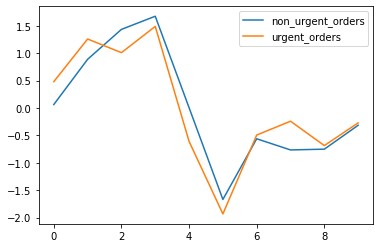

In [ ]:
month_1 = df.iloc[:39]
month_2 = df.iloc[39:]
agg_1 = month_1.groupby(['week_of_month'])[['non_urgernt_order','urgent_order']].sum()
agg_2 = month_2.groupby(['week_of_month'])[['non_urgernt_order','urgent_order']].sum()
agg_2.index = list(range(6,11))

ready_ts_data = pd.concat([agg_1,agg_2],axis=0)
#scale the data
scale = StandardScaler()
scale.fit(ready_ts_data)
ready_ts_data_scld = pd.DataFrame(scale.transform(ready_ts_data))
ready_ts_data_scld.columns = ['non_urgent_orders','urgent_orders']
ready_ts_data_scld.plot()

In [ ]:
#scaled data
date = pd.date_range(start='2017/01/01',periods=10,freq='W')
ready_ts_data_scld['date'] = date
ready_ts_data_scld.set_index('date',inplace=True)
orders_from_week_to_day = ready_ts_data_scld.resample('D')
orders_from_week_to_day = orders_from_week_to_day.interpolate(method='spline',order=2)

,non_urgernt_order,urgent_order
date,,
2017-03-01,755.845897,516.855426
2017-03-02,784.288782,534.964090
2017-03-03,816.420259,559.903998
2017-03-04,852.240327,591.675147
2017-03-05,891.705000,630.342000


In [ ]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

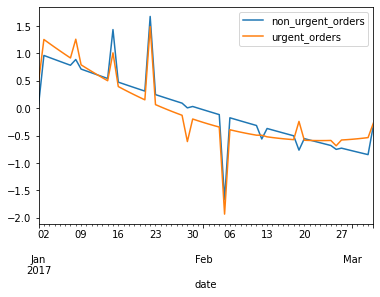

In [ ]:
orders_from_week_to_day.plot()

In [ ]:
#checking the if the timeseries is a stationary or not
adf, pvalue1, usedlag, nobs, critical_values, icbest = adfuller(orders_from_week_to_day['non_urgent_orders'],regression='c')
adf, pvalue2, usedlag, nobs, critical_values, icbest = adfuller(orders_from_week_to_day['urgent_orders'],regression='c')

print("pvalue of non-urgent order: {}".format(pvalue1))
print("pvalue of urgent order: {}".format(pvalue2))
#both of those timeseries are not stationary

pvalue of non-urgent order: 0.8179025690050652
pvalue of urgent order: 0.2620787016453745


In [ ]:
decompose = seasonal_decompose(x=orders_from_week_to_day,model='additive',freq=7)
data_trend = decompose.trend
data_seas = decompose.seasonal
data_res = decompose.resid

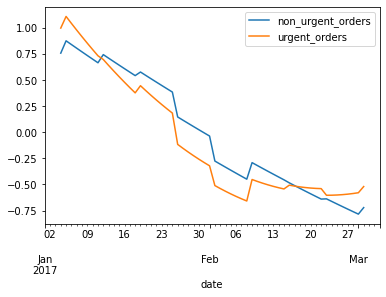

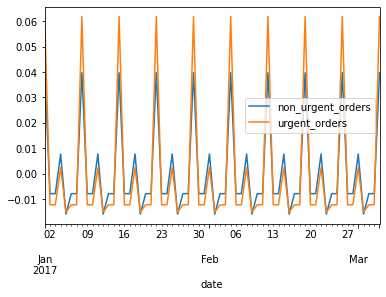

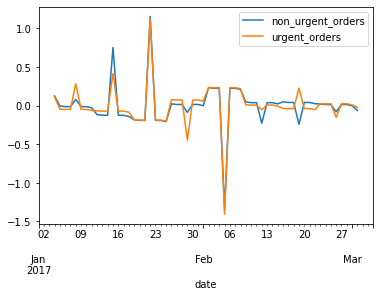

In [ ]:
data_trend.plot()
data_seas.plot()
data_res.plot()

In [ ]:
adf, pvalue_res1, usedlag, nobs, critical_values, icbest = adfuller(data_res['non_urgent_orders'][3:-3],regression='nc')
adf, pvalue2_res2, usedlag, nobs, critical_values, icbest = adfuller(data_res['urgent_orders'][3:-3],regression='nc')

print("pvalue of non-urgent order: {}".format(pvalue_res1))
print("pvalue of urgent order: {}".format(pvalue2_res2))
#both of those are stated as stationary, but the heterodasticity is undergo

pvalue of non-urgent order: 6.200417514153924e-07
pvalue of urgent order: 1.4598083294065348e-06


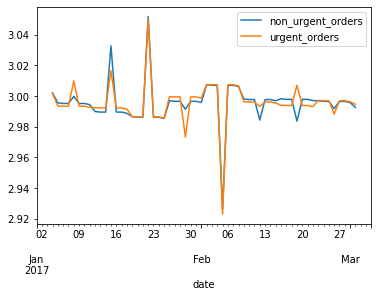

In [ ]:
data_res_log = np.log(data_res+20)
data_res_log.plot()
#there is no difference on log transformer

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
No handles with labels found to put in legend.


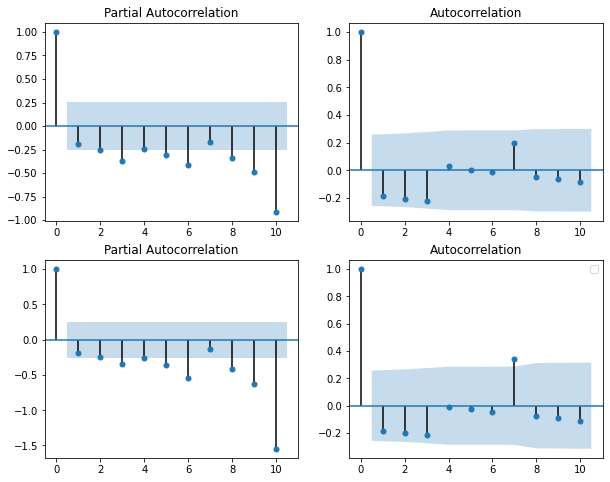

In [ ]:
# ACF and PACF plot to determine pdq
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(221)
fig = plot_pacf(data_res['urgent_orders'].dropna(),lags=10,ax=ax1)
ax2 = plt.subplot(222)
fig = plot_acf(data_res['urgent_orders'].dropna(),lags=10,ax=ax2)
ax3= plt.subplot(223)
fig = plot_pacf(data_res['non_urgent_orders'].dropna(),lags=10,ax=ax3)
ax4= plt.subplot(224)
fig = plot_acf(data_res['non_urgent_orders'].dropna(),lags=10,ax=ax4)
plt.legend()
plt.show()

In [ ]:
# we can conclude that 
# p = 1
# d = 1
# q = 0/1

In [ ]:
#ARIMA MODEL
arima_col1 = ARIMA(ready_ts_data['urgent_order'], order=(1,1,0))
arima_col2 = ARIMA(ready_ts_data['non_urgernt_order'], order=(1,1,0))
arima_fit_1 = arima_col1.fit()
arima_fit_2 = arima_col2.fit()
arima_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.urgent_order   No. Observations:                   63
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -253.214
Method:                       css-mle   S.D. of innovations             13.191
Date:                Sun, 18 Apr 2021   AIC                            512.429
Time:                        22:47:50   BIC                            518.858
Sample:                    01-02-2017   HQIC                           514.957
                         - 03-05-2017                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   20.4750     34.776      0.589      0.558     -47.686      88.635
ar.L1.D.urgent_order     0.9630      0.028     34.700      0.000       0.909       1.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0384           +0.0000j            1.0384            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
ready_ts_data['urgent_order_forecast'] = arima_fit_1.predict(start=55,end=75)
ready_ts_data['non_urgernt_order_forecast'] = arima_fit_2.predict(start=55,end=75)
#prediction and actual
ready_ts_data

,non_urgernt_order,urgent_order,urgent_order_forecast,non_urgernt_order_forecast
date,,,,
2017-01-01,1063.889000,860.443000,NaN,NaN
2017-01-02,1126.647832,921.155778,NaN,NaN
2017-01-03,1186.348326,972.798794,NaN,NaN
2017-01-04,1243.028573,1015.564120,NaN,NaN
2017-01-05,1296.688574,1049.451757,NaN,NaN
...,...,...,...,...
2017-03-01,755.845897,516.855426,5.039650,21.097556
2017-03-02,784.288782,534.964090,11.617963,24.652793
2017-03-03,816.420259,559.903998,18.196277,28.208030


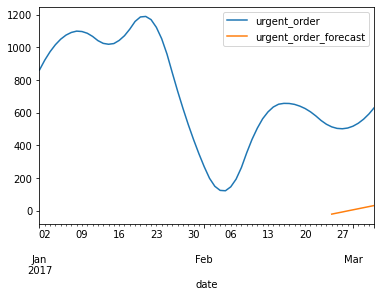

In [ ]:
ready_ts_data[['urgent_order','urgent_order_forecast']].plot()

In [ ]:
#SARIMA MODEL
sarima_col1 = SARIMAX(ready_ts_data['urgent_order'], order=(1,1,0),seasonal_order=(1,1,0,7))
sarima_col2 = SARIMAX(ready_ts_data['non_urgernt_order'], order=(1,1,0),seasonal_order=(1,1,0,7))

#sarima 1 for urgent order
sarima_fit_1 = sarima_col1.fit()
#sarima 2 for non urgent order
sarima_fit_2 = sarima_col2.fit()
sarima_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                      urgent_order   No. Observations:                   64
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -248.328
Date:                           Sun, 18 Apr 2021   AIC                            502.655
Time:                                   22:47:51   BIC                            508.731
Sample:                               01-01-2017   HQIC                           505.011
                                    - 03-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9563      0.045     21.089      0.000       0.867       1.045
ar.S.L7       -0.4518      0.141     -3.193      0.001      -0.729      -0.174
sigma2       391.6649    125.679      3.116      0.002     145.338     637.992
===================================================================================
Ljung-Box (Q):                      291.95   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               0.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.13   Kurtosis:                         1.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

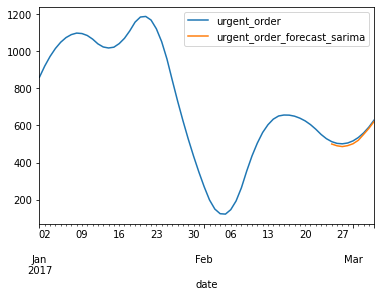

In [ ]:
ready_ts_data['urgent_order_forecast_sarima'] = sarima_fit_1.predict(start=55,end=75)
ready_ts_data['non_urgernt_order_forecast_sarima'] = sarima_fit_2.predict(start=55,end=75)
ready_ts_data[['urgent_order','urgent_order_forecast_sarima']].plot()

In [ ]:
# evaluation matrix 
# evaluate on last 15 days
ypred_15_day_arima = arima_fit_1.predict(start=46,end=len(ready_ts_data))
ypred_15_day_sarima = sarima_fit_1.predict(start=46,end=len(ready_ts_data))
ytrue = ready_ts_data[45:]['urgent_order']

MSE_arima = MSE(ytrue,ypred_15_day_arima)
MSE_sarima = MSE(ytrue,ypred_15_day_sarima)
print("the MSE of ARIMA model :{}".format(MSE_arima))
print("the MSE of SARIMA model :{}".format(MSE_sarima))

the MSE of ARIMA model :337845.58800338535
the MSE of SARIMA model :417.7806319328394


In [ ]:
#forecast on 19 days forward
forecast_dataset = [ready_ts_data.index[-1] + DateOffset(days=x) for x in range(20)]
#the index start from the next day of our most recent observation 
forecast_dataset = pd.DataFrame(index=forecast_dataset[1:], columns=ready_ts_data.columns)
#concat on rows
future_df = pd.concat([ready_ts_data,forecast_dataset])

In [ ]:
#past data have 64 observation
#future data have 83 observation with 19 to predict
future_df['urgent_order_forecast_sarima'] = sarima_fit_1.predict(start=63,end=83,dynamic=True)
future_df['non_urgernt_order_forecast_sarima'] = sarima_fit_2.predict(start=63,end=83,dynamic=True)

In [ ]:
#past data have 64 observation
#future data have 83 observation with 19 to predict
future_df['urgent_order_forecast'] = arima_fit_1.predict(start=63,end=83,dynamic=True)
future_df['non_urgernt_order_forecast'] = arima_fit_2.predict(start=63,end=83,dynamic=True)

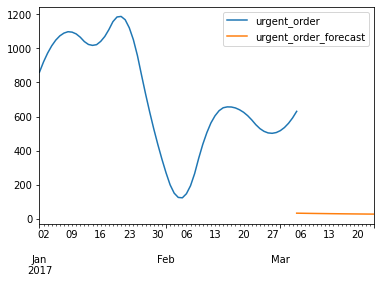

In [ ]:
#plotting the forecasted data ARIMA model
future_df[['urgent_order','urgent_order_forecast']].plot()

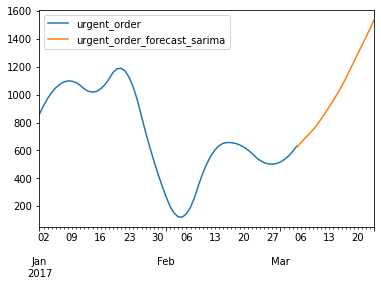

In [ ]:
#plotting the forecasted data with SARIMA model
future_df[['urgent_order','urgent_order_forecast_sarima']].plot()

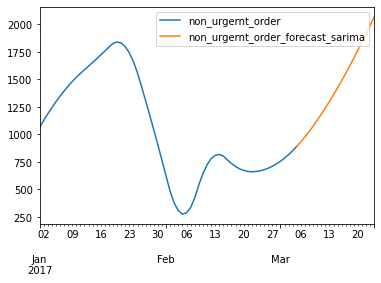

In [ ]:
#plotting the forecasted data
future_df[['non_urgernt_order','non_urgernt_order_forecast_sarima']].plot()

In [ ]:
# deep learning model
# create a function to provide LSTM input

def input_sequence(timeseries, step):
    X,y = [],[]
    for each in range(len(timeseries) - 1):
    #last index for output
        y_ix = each + step
      #prevent last index beyond series length
        if y_ix > len(timeseries)-1 :
            break
        x_seq = timeseries[each : y_ix]
        y_seq = timeseries[y_ix]
        X.append(x_seq)
        y.append(y_seq)
    return np.array(X),np.array(y)

In [ ]:
#due to lack of dataset observation we use 3 step
trainX_urgent,trainy_urgent = input_sequence(ready_ts_data['urgent_order'][:51],3)
testX_urgent,testy_urgent = input_sequence(ready_ts_data['urgent_order'][51:],3)

trainX_nonurgent,trainy_nonurgent = input_sequence(ready_ts_data['non_urgernt_order'][:51],3)
testX_nonurgent,testy_nonurgent = input_sequence(ready_ts_data['non_urgernt_order'][51:],3)

In [ ]:
for i in range(len(trainX_urgent)):
    print(trainX_urgent[i],trainy_urgent[i])

[860.443      921.15577802 972.79879364] 1015.5641198013147
[ 921.15577802  972.79879364 1015.5641198 ] 1049.4517565048159
[ 972.79879364 1015.5641198  1049.4517565 ] 1074.4617037510245
[1015.5641198  1049.4517565  1074.46170375] 1090.593961539941
[1049.4517565  1074.46170375 1090.59396154] 1098.742
[1074.46170375 1090.59396154 1098.742     ] 1096.2254087458969
[1090.59396154 1098.742      1096.22540875] 1085.7245981629364
[1098.742      1096.22540875 1085.72459816] 1066.3460981226835
[1096.22540875 1085.72459816 1066.34609812] 1040.626888388111
[1085.72459816 1066.34609812 1040.62688839] 1023.7888475370535
[1066.34609812 1040.62688839 1023.78884754] 1018.3689553324828
[1040.62688839 1023.78884754 1018.36895533] 1022.597
[1023.78884754 1018.36895533 1022.597     ] 1041.7836168628035
[1018.36895533 1022.597      1041.78361686] 1070.6181705976946
[1022.597      1041.78361686 1070.6181706 ] 1110.870872979073
[1041.78361686 1070.6181706  1110.87087298] 1158.0788642267632
[1070.6181706  111

In [ ]:
# requuired library
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [ ]:
lstm_model = Sequential()
#the input shape is sequence length and number of feature
lstm_model.add(LSTM(100,activation='relu', input_shape=(3,1),return_sequences=True))
lstm_model.add(LSTM(50,activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam',loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainX_urgent.shape

(48, 3)

In [ ]:
X_train_u = trainX_urgent.reshape(trainX_urgent.shape[0],trainX_urgent.shape[1],1)
X_test_u = testX_urgent.reshape(testX_urgent.shape[0],testX_urgent.shape[1],1)

history_u = lstm_model.fit(X_train_u,trainy_urgent,epochs=100,batch_size=20,validation_data=(X_test_u,testy_urgent))

Epoch 1/100
3/3 [==============================] - 4s 395ms/step - loss: 690704.7656 - mean_squared_error: 690704.7656 - val_loss: 291422.0000 - val_mean_squared_error: 291422.0000
Epoch 2/100
3/3 [==============================] - 0s 33ms/step - loss: 669763.8594 - mean_squared_error: 669763.8594 - val_loss: 271820.4688 - val_mean_squared_error: 271820.4688
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 595721.6562 - mean_squared_error: 595721.6562 - val_loss: 239850.7500 - val_mean_squared_error: 239850.7500
Epoch 4/100
3/3 [==============================] - 0s 27ms/step - loss: 533002.9141 - mean_squared_error: 533002.9141 - val_loss: 224191.9531 - val_mean_squared_error: 224191.9531
Epoch 5/100
3/3 [==============================] - 0s 28ms/step - loss: 483782.7812 - mean_squared_error: 483782.7812 - val_loss: 198008.2344 - val_mean_squared_error: 198008.2344
Epoch 6/100
3/3 [==============================] - 0s 29ms/step - loss: 448868.3359 - mean_squared_

In [ ]:
history_u.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [ ]:
history_u.history['val_loss'][-1]

789.4143676757812

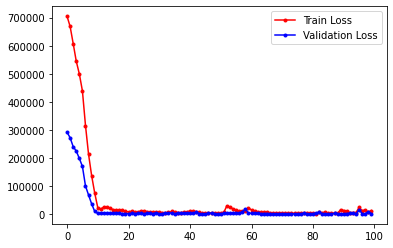

In [ ]:
fig,ax = plt.subplots()
ax.plot(history_u.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(history_u.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
#try to predict
X_future = np.array([[771.232,519.894,655.442],
                     [690.221,781.001,591.999]]).reshape(2,3,1)

In [ ]:
forecast_val_u = lstm_model.predict(X_future)
forecast_val_u

array([[613.9784],
       [694.4696]], dtype=float32)